Read documentation.

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Iterable, Callable
from itertools import combinations
from math import exp
from scipy.optimize import linprog
from numpy.typing import NDArray
from numpy.linalg import LinAlgError
from typing import Optional

In [2]:
def cash_flow_present_value(cash_flow, effective_rate):
    """Enter effective rate in percentage"""
    r = 1 + effective_rate / 100
    res = 0
    for i, ai in enumerate(cash_flow):
        res += ai / r ** i
    return res

## Example: Find the present value of the cash flow (0, 1, 2, 3, 4, 5, 6, 7) at 11% annual interest rate
flow = (0, 1, 2, 3, 4, 5, 6, 7)
rate = 11
cash_flow_present_value(flow, rate)

16.899354340933023

In [3]:
def internal_rate_return(cash_flow) -> float:
    """Returns IRR in percentage"""
    coeffs = list(reversed(cash_flow))
    roots = np.roots(coeffs)
    positiveRoots: list[complex] = list(filter(lambda x: abs(x.imag) < 0.0001 and x.real > 0, roots))
    if len(positiveRoots) > 1:
        print(list(1/c.real - 1 for c in positiveRoots))
        raise ValueError("There are more than one positive roots")
    if len(positiveRoots) == 0:
        raise ValueError("There are no positive roots")
    x, = positiveRoots
    return (1/x.real - 1) * 100

## Example: Example 2.3 - find the IRR of (-2, 1, 1, 1)
flow = (-2, 1, 1, 1)
internal_rate_return(flow)

23.375192852825855

In [4]:
def annuity_price(payment, rate, num_period):
    """Consider an annuity that begins payment one period from the
    present, paying an amount A each period for a total of n periods. The present value
    P, the one-period annuity amount A, the one-period interest rate r, and the number
    of periods n of the annuity are related by this function.

    Calculates price of annuity. Enter rate in percentage"""
    A = payment
    r = rate/100
    n = num_period

    return A / r * (1 - 1/(1 + r) ** n)

def annuity_payment(price, rate, num_period):
    P = price
    r = rate/100
    n = num_period

    return (r * (1 + r) ** n * P)/((1 + r) ** n - 1)


## Example: Example 3.2 Suppose you have borrowed $1,000 from a credit
# union. The terms of the loan are that the yearly interest is 12% compounded monthly.
# You are to make equal monthly payments of such magnitude as to repay (amortize)
# this loan over 5 years. How much are the monthly payments?

monthly_rate = 1
num_months = 5 * 12
price = 1000

payment = annuity_payment(price, monthly_rate, num_months)
print(f"A = {payment}")

# We double check using the other function
price = annuity_price(payment, monthly_rate, num_months)
print(f"P = {price}")

A = 22.24444768490176
P = 1000.0


Bonds stuff

In [5]:
class Bond:
    """Implementation of a bond. A face value $30000, 9% bond that matures in 30 periods (years) that pays its coupons twice a period (year) should be entered as Bond(9, 30, 2, 300)"""
    def __init__(self, coupon_percentage, maturity_years, coupon_freq, face_value):
        self.percentage = coupon_percentage / 100
        self.maturity_years = maturity_years
        self.coupon_freq = coupon_freq
        self.face_value = face_value
        flow = [0] + [coupon_percentage / coupon_freq] * maturity_years * coupon_freq
        flow[-1] += face_value
        self.flow = tuple(flow)
    
    @property
    def coupon_payment(self):
        return self.percentage * self.face_value / self.coupon_freq

In [6]:
def bond_ytm(bond, price, remaining_periods = None):
    """Calculates the yield to maturity (in percentage). Remaining Periods is the number of remaining coupon payments until maturity.
    If remaining periods is set to none, we assume the full duration of the bond"""
    if remaining_periods is None:
        remaining_periods = bond.coupon_freq * bond.maturity_years
    flow = [-price] + [bond.coupon_payment] * remaining_periods
    flow[-1] += bond.face_value
    irr = internal_rate_return(flow)
    return irr * bond.coupon_freq

def bond_price(bond, yield_to_maturity: float, remaining_periods = None):
    """Calculate the price of the bond based on its yield to maturity. The price and yield operations should be inverses to each other, given the same number of remaining periods until maturity.
    Please enter your yield to maturity in percentages"""
    if remaining_periods is None:
        remaining_periods = bond.coupon_freq * bond.maturity_years
    
    m = bond.coupon_freq
    F = bond.face_value
    C = bond.percentage * bond.face_value
    y = yield_to_maturity / 100
    n = remaining_periods

    fac = 1 / (1 + y / m) ** n
    return F * fac + C / y * (1 - fac)


## Example: Cross check table 3.5

# TABLE 3.5
# PRICES OF 9% COUPON BONDS
# Yield
# Time to maturity  5%      8%      9%      10%     15%
# 1 year            103.85  100.94  100.00  99.07   94.61
# 5 years           117.50  104.06  100.00  96.14   79.41
# 10 years          131.18  106.80  100.00  93.77   69.42
# 20 years          150.21  109.90  100.00  91.42   62.22
# 30 years          161.82  111.31  100.00  90.54   60.52

# 1 year, 100 dollars, 9% coupon, coupons twice a year
bond = Bond(9, 1, 2, 100)
print(bond_ytm(bond, 103.85, 2))
print(bond_price(bond, 5, 2))

print()

# Other entries
entries = np.zeros((5, 5))
for i, years in enumerate((1, 5, 10, 20, 30)):
    for j, yld in enumerate((5, 8, 9, 10, 15)):
        # Pays twice a year so remains 2 * years number of coupon payment periods
        # so the non-lazy way to enter this should be price = bond_price(bond, yld, 2 * years)
        # but we can skip the entry for remaining periods - we will assume the full duration of the bond
        bond = Bond(9, years, 2, 100)
        price = bond_price(bond, yld)
        entries[i, j] = price

entries = np.round(entries, 2)
print(entries)

5.004888552088005
103.8548483045806

[[103.85 100.94 100.    99.07  94.61]
 [117.5  104.06 100.    96.14  79.41]
 [131.18 106.8  100.    93.77  69.42]
 [150.21 109.9  100.    91.42  62.22]
 [161.82 111.31 100.    90.54  60.52]]


In [7]:
def duration(bond, yield_to_maturity, remaining_periods = None, payment_k = None):
    """Payment k is the c_k term in the textbook - the amount of payment at payment period k.
    If set to None (by default), payment_k is the fixed coupon payment calculated from face value and coupon percentage
    Please enter your yield to maturity in percentage"""
    if remaining_periods is None:
        remaining_periods = bond.coupon_freq * bond.maturity_years
    
    if payment_k is None:
        payment_k = [bond.coupon_payment] * remaining_periods
        payment_k[-1] += bond.face_value
    
    assert len(payment_k) == remaining_periods, f"Number of payments :{len(payment_k)} not equal to number of remaining periods {remaining_periods}"

    top, PVofPayment = 0., 0.
    for k in range(remaining_periods):
        price = payment_k[k] / (1 + yield_to_maturity / 100 / bond.coupon_freq) ** (k + 1)
        top += ((k + 1) / bond.coupon_freq) * price
        PVofPayment += price
    return top / PVofPayment

def modified_duration(bond, yield_to_maturity, remaining_periods = None, payment_k = None):
    y = yield_to_maturity / 100
    m = bond.coupon_freq
    return - duration(bond, yield_to_maturity, remaining_periods, payment_k)/(1 + y/m)

## Example: Example 3.6
# Consider a 7% bond with 3 years to maturity. Assume
# that the bond is selling at 8% yield [...] The duration is 2.753 years.

bond = Bond(7, 3, 2, 100)
print(duration(bond, 8))

## Example: We can actually calculate the duration for a floating rate bond, albeit this is a caveman way of doing it
# Consider a bond with 3 years to maturity selling at 8% yield. Suppose the spot rates are (5%, 6%, 7%).

payment_1 = 100 * 1.05
payment_2 = 100 * 1.05 * 1.06
payment_3 = 100 * 1.05 * 1.06 * 1.07
payments = [payment_1, payment_2, payment_3]

# The drawback of having this step-by-step process is sometimes we need placeholder values. Enter 0 as a placeholder
bond = Bond(0, 3, 1, 100)
print(duration(bond, 8, payment_k = payments))

2.753717024504417
1.9906542056074767


In [8]:
def solve_rates(fw_rates: dict[tuple[int, int], float], mode: int = 1, verbose = False):
    """Enter a list of (i, j, f_{i, j}), then this function will solve for every possible forward rates, then calculate all the discount factors.
    Keep in mind that the i-th spot rate s_i is equivalent to f_{0, i} by definition, and that discount factors and forwards rates have a simple relation

    dij = (1/(1+fij))**(j-i)

    Enter the rates as percentages.

    Compounding mode: if continuous, enter -1, otherwise enter the number of times money is compounded every year.

    Verbose: if set to true, then the function will print out all the forward rates and discount factors for us
    
    Remark: This is the pinnacle of over-engineered garbage. Dont do drugs kids"""

    # f takes i, j, si, sj and returns f_{i, j}. This formula is determined by the mode of compounding
    fik: Callable[[int, int, int, float, float], float]
    fij: Callable[[int, int, int, float, float], float]
    fjk: Callable[[int, int, int, float, float], float]
    if mode == -1:
        # exp(fik * (k - i)) = exp(fij * (j - i)) exp(fjk * (k - j))
        # fik * (k - i) = fij * (j - i) + fjk * (k - j)
        fik = lambda i, j, k, fij, fjk: (fij * (j - i) + fjk * (k - j))/(k - i)
        fij = lambda i, j, k, fik, fjk: (fik * (k - i) - fjk * (k - j))/(j - i)
        fjk = lambda i, j, k, fij, fik: (fik * (k - i) - fij * (j - i))/(k - j)
    elif mode > 0:
        # (1 + fik/m)**m(k-i) = (1 + fij/m)**m(j-i) (1 + fjk/m)**m(k-j)
        fik = lambda i, j, k, fij, fjk: (((1 + fij/mode)**(j-i) * (1 + fjk/mode)**(k-j))**(1/(k-i)) - 1) * mode
        fij = lambda i, j, k, fik, fjk: (((1 + fik/mode)**(k-i)/(1 + fjk/mode)**(k-j))**(1/(j-i)) - 1) * mode
        fjk = lambda i, j, k, fij, fik: (((1 + fik/mode)**(k-i)/(1 + fij/mode)**(j-i))**(1/(k-j)) - 1) * mode
    else:
        raise ValueError(f"Invalid mode. Expects -1 (for continuous) or >= 1 (for n periods per year), recieved {mode}")

    # Translate everything from percentage to decimals
    decimal_fw = {(i, j): fij/100 for (i, j), fij in fw_rates.items() if j > i}

    # Find the maximum number of years we are concerned about, leveraging the fact that j > i
    max_years = max({j for (_, j) in decimal_fw.keys()})

    # Model this as a graph theory problem. We say two nodes i, j are connected if f_{i, j} is calculated
    # Go through the list of all nodes:
    #   If the node i has at least two adjacent neighbours j, k
    #       For each pair j0, k0 of i's neighbours:
    #           If j0, k0 are connected then continue the loop, otherwise solve for fjk using the above formula
    #           Append the node into decimal fw
    #           Set a flag to true - this means we changed something and we need to loop again
    N = max_years + 1

    def solve_neighbours(i: int, neighbours: list[int]):
        flag: bool = False
        for j, k in combinations(neighbours, 2):
            if j > k:
                j, k = k, j
            if (j, k) in decimal_fw.keys():
                continue
            if i < j < k:
                new_fjk = fjk(i, j, k, decimal_fw[(i, j)], decimal_fw[(i, k)])
                decimal_fw[(j, k)] = new_fjk
                flag = True
            elif j < i < k:
                new_fik = fik(j, i, k, decimal_fw[(j, i)], decimal_fw[(i, k)])
                decimal_fw[(j, k)] = new_fik
                flag = True
            elif j < k < i:
                new_fij = fij(j, k, i, decimal_fw[(j, i)], decimal_fw[(k, i)])
                decimal_fw[(j, k)] = new_fij
                flag = True
            else:
                raise ValueError(f"Recieved unexpected triplets of i, j, k: {i}, {j}, {k}")
        return flag

    flag = True
    while flag:
        flag = False
        for i in range(N):
            neighbours = [j for j in range(N) if ((i, j) in decimal_fw.keys() or (j, i) in decimal_fw.keys())]
            if len(neighbours) >= 2:
                flag = solve_neighbours(i, neighbours)


    # Change back to percentage
    percentage_fw = {(i, j): x*100 for (i, j), x in decimal_fw.items()}

    if verbose:
        for (i, j) in sorted(decimal_fw.keys()):
            fw_rate = decimal_fw[(i, j)]
            print(f"Forward rate: f({i}, {j}) = {fw_rate * 100}")
            print(f"Discount factor: d({i}, {j}) = {(1/(1 + fw_rate)) ** (j - i)}")

    return percentage_fw

## Example: Quiz 3 Q3-6. We are given the following forward rates: (Keep in mind spot rates s[i] are just forward rates f[0, i] in disguise)
rates = {
    (0, 2): 6.9,
    (0, 3): 7.5,
    (0, 5): 8.4,
    (0, 6): 10,
    (1, 2): 7.8,
    (2, 3): 8.7,
    (1, 3): 8.25,
    (2, 4): 11.55
}

# For continuous compounding, enter mode = -1
solve_rates(rates, mode = -1, verbose = True)
print()

# Now read off the print statements, Q3 asking for s1 = f[0, 1] = 6%
# Q4 asking for s4 = 9.225%
# Q6 asking for f[5, 6] = 18%

Forward rate: f(0, 1) = 6.000000000000001
Discount factor: d(0, 1) = 0.9433962264150942
Forward rate: f(0, 2) = 6.9
Discount factor: d(0, 2) = 0.8750736155679096
Forward rate: f(0, 3) = 7.5
Discount factor: d(0, 3) = 0.8049605695096029
Forward rate: f(0, 4) = 9.225
Discount factor: d(0, 4) = 0.7026058904493938
Forward rate: f(0, 5) = 8.4
Discount factor: d(0, 5) = 0.6681186408937176
Forward rate: f(0, 6) = 10.0
Discount factor: d(0, 6) = 0.5644739300537773
Forward rate: f(1, 2) = 7.8
Discount factor: d(1, 2) = 0.9276437847866419
Forward rate: f(1, 3) = 8.25
Discount factor: d(1, 3) = 0.8533833984927115
Forward rate: f(1, 4) = 10.299999999999999
Discount factor: d(1, 4) = 0.7452010577678913
Forward rate: f(1, 5) = 9.000000000000002
Discount factor: d(1, 5) = 0.7084252110651964
Forward rate: f(1, 6) = 10.8
Discount factor: d(1, 6) = 0.5988267578627791
Forward rate: f(2, 3) = 8.7
Discount factor: d(2, 3) = 0.9199632014719411
Forward rate: f(2, 4) = 11.55
Discount factor: d(2, 4) = 0.80363

In [9]:
# Here is another example: Table 4.2
rates = {
    (0, 1): 6.00, 
    (0, 2): 6.45, 
    (0, 3): 6.80,
    (0, 4): 7.10, 
    (0, 5): 7.36, 
    (0, 6): 7.56,
    (0, 7): 7.77
}

solve_rates(rates, mode = 1, verbose = True)
print()

Forward rate: f(0, 1) = 6.0
Discount factor: d(0, 1) = 0.9433962264150942
Forward rate: f(0, 2) = 6.45
Discount factor: d(0, 2) = 0.8824877152194492
Forward rate: f(0, 3) = 6.800000000000001
Discount factor: d(0, 3) = 0.8208924132886746
Forward rate: f(0, 4) = 7.1
Discount factor: d(0, 4) = 0.7600499183171738
Forward rate: f(0, 5) = 7.359999999999999
Discount factor: d(0, 5) = 0.7011121379638915
Forward rate: f(0, 6) = 7.5600000000000005
Discount factor: d(0, 6) = 0.6457958334297162
Forward rate: f(0, 7) = 7.77
Discount factor: d(0, 7) = 0.5922632971085996
Forward rate: f(1, 2) = 6.901910377358478
Discount factor: d(1, 2) = 0.9354369781326164
Forward rate: f(1, 3) = 7.202261310984848
Discount factor: d(1, 3) = 0.8701459580859953
Forward rate: f(1, 4) = 7.469197529648763
Discount factor: d(1, 4) = 0.8056529134162046
Forward rate: f(1, 5) = 7.702717718733743
Discount factor: d(1, 5) = 0.7431788662417252
Forward rate: f(1, 6) = 7.87474427773871
Discount factor: d(1, 6) = 0.684543583435499

In [10]:
def QM_duration(cash_flow_or_bond, rates, compound_freq):
    """Enter a list of spot rates (in percentage) to calculate the quasi-modified duration.
    Keep in mind if the price at rates = sk + y is P(y), then P'(0) = -Dq * P(0)

    This trims the first term to keep consistent with the bond calculations. i.e. following the book. calculating the
    quasimodified duration for (x0, x1, ..., xn) where x0 is the flow on year 0
    
    You can actually feed a bond into this function and we will handle it for you"""
    if isinstance(cash_flow_or_bond, Bond):
        cash_flow = cash_flow_or_bond.flow
    else:
        cash_flow = cash_flow_or_bond
    
    assert len(cash_flow) <= len(rates) + 1, f"Wrong number of periods: we have {len(rates)} years of spot rates but {len(cash_flow)} years bond"

    # First calculate the pv of cash flow
    spr = [1] + [1 + r/100 for r in rates]
    res = 0
    for i, ai in enumerate(cash_flow):
        res += ai / (spr[i]) ** i
    PV = res

    x = cash_flow[1:]
    s = [1 + r/100 for r in rates]
    m = compound_freq
    n = len(cash_flow) - 1
    res = 0.
    for _k in range(n):
        k = _k + 1
        rs = (k/m) * x[_k] * (s[_k]) ** (-k-1)
        res += rs
    return res/PV

# Example: From within example 4.8. Let spot rates be (7.67, 8.27, 8.81, 9.31, 9.75), the bond is a 5-year 10% bond.
# Find the quasi-modified_duration of said bond

rates = (7.67, 8.27, 8.81, 9.31, 9.75)
cash_flow = [0, 10, 10, 10, 10, 110]
print(QM_duration(cash_flow, rates, 1))

# Less error prone way
bond = Bond(10, 5, 1, 100)
print(QM_duration(bond, rates, 1))

3.7981038674959344
3.7981038674959344


In [11]:
def immunize_parallel(bond1: Bond, bond2: Bond, obligation_cash_flow, rates, verbose: bool = False):
    # Calculate the PVob, Dob of obligation
    # Calculate the PV1, D1 of bond1
    # Calculate the PV2, D2 of bond2

    obligation = obligation_cash_flow

    # First do error checking
    num_years_total = max(bond1.maturity_years, bond2.maturity_years, len(obligation) - 1)
    enough_rates = len(rates) >= num_years_total
    if not enough_rates:
        raise ValueError(f"Expected at least {num_years_total} years of rates, found {len(rates)}")

    spr = [1] + [1 + r/100 for r in rates]
    PVob = 0
    for i, ai in enumerate(obligation):
        PVob += ai / (spr[i]) ** i
    
    PV1 = 0
    for i, ai in enumerate(bond1.flow):
        PV1 += ai / (spr[i]) ** i

    PV2 = 0
    for i, ai in enumerate(bond2.flow):
        PV2 += ai / (spr[i]) ** i
    
    Dob = QM_duration(obligation, rates, 1)
    D1 = QM_duration(bond1, rates, 1)
    D2 = QM_duration(bond2, rates, 1)

    if verbose:
        print(f"Duration of bond 1: {D1}")
        print(f"Duration of bond 2: {D2}")
        print(f"Duration of obligation: {Dob}")
        print(f"Present value of bond 1: {PV1}")
        print(f"Present value of bond 2: {PV2}")
        print(f"Present value of obligation: {PVob}")

    # Solve for
    # PV1   PV2     x1 = PVob
    # PV1D1 PV2D2   x2 = PVob Dob

    # Hence
    # x1 =  |PV1   PV2  |-1  |PVob    |
    # x2 =  |PV1D1 PV2D2|    |PVob Dob|
    det = PV1 * PV2 * D2 - PV2 * PV1 * D1
    if abs(det) < 1e-5:
        raise ValueError("This portfolio cannot be immunized - the equations have no solutions")

    x1 = 1/det * (PV2 * PVob * D2 - PVob * Dob * PV2)
    x2 = 1/det * (PV1 * PVob * Dob - PVob * D1 * PV1)

    if verbose:
        print(f"Buy {x1} units of bond 1 and {x2} units of bond 2")

    return x1, x2

## Example: example 4.8 - suppose we have a 1M obligation in 5 years, B1 is a 12-year 6%
# bond with price 65.95, and B2 is a 5-year 10% bond with price 101.66.

B1 = Bond(6, 12, 1, 100)
B2 = Bond(10, 5, 1, 100)
obligation = (0, 0, 0, 0, 0, 1_000_000)
rates = (7.67, 8.27, 8.81, 9.31, 9.75, 10.16, 10.52, 10.85, 11.15, 11.42, 11.67, 11.89)
immunize_parallel(B1, B2, obligation, rates, verbose = True)

Duration of bond 1: 7.065794607835234
Duration of bond 2: 3.7981038674959344
Duration of obligation: 4.555808656036446
Present value of bond 1: 65.95141593517083
Present value of bond 2: 101.66772356861858
Present value of obligation: 628025.6120440393
Buy 2208.067349270539 units of bond 1 and 4744.8730722670425 units of bond 2


(2208.067349270539, 4744.8730722670425)

In [12]:
# Given list of bonds and obligations find optimal portfolio
def optimize_portfolio(bonds: list[Bond], price: list[float], obligations: list[float], verbose: bool = False):
    """Given a list of bonds and obligations find the optimal portfolio to satisfy the obligations"""

    # Layout bonds in a grid where columns are bond payments
    # Pass it into scipy function
    # Figure out what scipy is returning

    assert len(bonds) == len(price), f"Number of bonds ({len(bonds)}) does not equal to number of prices ({len(price)})"

    num_cols = len(bonds)
    num_rows = max([len(b.flow) for b in bonds]) - 1
    arr = np.zeros((num_rows, num_cols), dtype = np.float32)

    for i in range(num_rows):
        for j in range(num_cols):
            try:
                arr[i, j] = bonds[j].flow[i+1]
            except IndexError:
                arr[i, j] = 0

    p = np.array(price)
    if len(obligations) == num_rows:
        obls = np.array(obligations, dtype = np.float32)
    elif len(obligations) < num_rows:
        obligations += [0] * (num_rows - len(obligations))
        obls = np.array(obligations, dtype = np.float32)
    else:
        raise ValueError(f"Could not calculate obligations - there are more obligation years ({len(obligations)}) than bonds ({num_rows})")

    result = linprog(p, -arr, -obls)

    x = list(result.x)

    if verbose:
        for i in range(num_cols):
            print(f"Buy {x[i]} units of bond {i} ({bonds[i].percentage * 100}% payments and {bonds[i].maturity_years} years)")

    return x

## Example: Example 5.3:
obligations = (100, 200, 800, 100, 800, 1200)
prices = (109, 94.8, 99.5, 93.1, 97.2, 92.9, 110, 104, 102, 95.2)
bonds = [
    Bond(10, 6, 1, 100),
    Bond(7, 6, 1, 100),
    Bond(8, 6, 1, 100),
    Bond(6, 5, 1, 100),
    Bond(7, 5, 1, 100),
    Bond(5, 4, 1, 100),
    Bond(10, 3, 1, 100),
    Bond(8, 3, 1, 100),
    Bond(7, 2, 1, 100),
    Bond(0, 1, 1, 100)
]

# Keep in mind computers count from 0
optimize_portfolio(bonds, prices, obligations, verbose = True)
print()

Buy 0.0 units of bond 0 (10.0% payments and 6 years)
Buy 11.214953271028037 units of bond 1 (7.000000000000001% payments and 6 years)
Buy 0.0 units of bond 2 (8.0% payments and 6 years)
Buy 6.806559689649092 units of bond 3 (6.0% payments and 5 years)
Buy 0.0 units of bond 4 (7.000000000000001% payments and 5 years)
Buy 0.0 units of bond 5 (5.0% payments and 4 years)
Buy 0.0 units of bond 6 (10.0% payments and 3 years)
Buy 6.302370083008418 units of bond 7 (8.0% payments and 3 years)
Buy 0.28258886262469046 units of bond 8 (7.000000000000001% payments and 2 years)
Buy 0.0 units of bond 9 (0.0% payments and 1 years)



In [13]:
class OptimizeStockPortfolio:
    def __init__(self, expected_returns: list[float], covariances: NDArray[np.float64]):
        """Solves the Markovitz problem. Refer to the example below"""
        r, w = covariances.shape
        self.n = len(expected_returns)

        if r != w or r != self.n:
            raise ValueError(f"Expected number of stocks equal number of correlations... got number of stocks: {self.n}, correlation array: {r}x{w}")

        if not np.all(covariances - covariances.T < 1e-6): #type: ignore
            raise ValueError(f"Expected the covariance to be a symmetric matrix")

        # if np.all(np.abs(covariances.diagonal() - 1) < 1e-6): #type: ignore
        #     print("All diagonal entries are 1, did you enter the correlation matrix?")

        self.expecteds = np.array(expected_returns)
        self.covariances = np.array(covariances)

    def returns(self, weights: NDArray[np.float64]) -> tuple[float,float]: #type: ignore
        r = weights.dot(self.expecteds)
        sd = weights.T @ self.covariances @ weights
        return r, sd #type: ignore

    def solve_montecarlo_minimize(self, f_min: Callable[[NDArray[np.float64], NDArray[np.float64]], NDArray[np.float64]], weights: NDArray[np.float64], show_plot: bool = True, verbose: bool = True):
        """Solves the Markowitz problem numerically with arbitrary obtimization constraints.
        f takes in a 1D array of mean and 1D array of variances and returns a new 1D array of values"""
        mean = np.dot(weights, self.expecteds)
        sd = np.sqrt((weights.dot(self.covariances) * weights).sum(-1))
        optimized = f_min(mean, sd)
        best_idx = np.argmin(optimized)

        if optimized.shape != mean.shape:
            raise ValueError(f"Expected the shape of the optimized array to be {mean.shape}, found {optimized.shape}")

        # The condition to determine the best is sligghttttly different
        # best_r = mean[best_idx]
        # best_sd = sd[best_idx]
        best_weight = weights[best_idx]
        best_r, best_sd = self.returns(best_weight)

        if verbose:
            print(f"Best average return: {best_r}")
            print(f"Minimum standard deviation: {best_sd}")
            print(f"Best weights: {np.round(best_weight, 2)}")

        if show_plot:
            plt.figure()
            plt.xlim((0, np.max(sd)))
            plt.ylim((0, np.max(mean)))
            lerp_colors = (optimized-np.min(optimized))/(np.max(optimized)-np.min(optimized))
            plt.scatter(sd, mean, c=lerp_colors, cmap="winter", s=0.1, alpha=0.5)
            plt.show()

        return best_r, best_sd, best_weight

    def get_weights_(self, shorting, num_plot):
        if not shorting:
            weights = np.random.random(size=(num_plot, self.n))
            weights = np.multiply(weights, 1/(np.sum(weights, axis = 1).reshape((-1, 1)) + np.zeros((1, self.n))))
        else:
            # Generate multivariate normal distribution in n-1 variables, and the n-th one will be the negative of the sum of the rest
            # Mean 0 variance 1
            weights_ = np.random.default_rng().multivariate_normal(np.zeros((self.n-1,)), np.eye(self.n-1), size=(num_plot,))
            weights = np.zeros((num_plot, self.n))
            weights[:, :-1] = weights_
            weights[:, -1] = 1-np.sum(weights_, axis = 1)
        return weights

    def solve_montecarlo(self, num_plot: int = 999999, shorting: bool = True, show_plot: bool = True, verbose: bool = True):
        """Solves the Markowitz problem numerically."""
        weights = self.get_weights_(shorting, num_plot)
        f = lambda mean, sd: sd
        r, sd, w = self.solve_montecarlo_minimize(f, weights, show_plot, verbose)
        return w

    # Note: This function performs really poorly
    # def solve_montecarlo_target_return(self, target_mean_return: float, num_plot: int = 999999, shorting: bool = True, show_plot: bool = True, verbose: bool = True):
    #     """Solves the Markowitz problem numerically."""
    #     weights = self.get_weights_(shorting, num_plot)
    #     f = lambda mean, sd: 99999 * np.abs(mean - target_mean_return) + sd
    #     r, sd, w = self.solve_montecarlo_minimize(f, weights, show_plot, verbose)
    #     return w

    def solve_tan_montecarlo(self, risk_free_rate: float, num_plot: int = 999999, shorting: bool = True, show_plot: bool = True, verbose: bool = True):
        weights = self.get_weights_(shorting, num_plot)
        # We want to maximize the tangent
        f = lambda mean, sd: (risk_free_rate-mean)/sd
        r, sd, w = self.solve_montecarlo_minimize(f, weights, show_plot, verbose)
        return w

    def solve_analytical(self):
        n, = self.expecteds.shape
        A = np.array(self.covariances)
        b = np.ones((n,))

        A_inv: NDArray[np.float64]

        try:
            A_inv = np.linalg.inv(A)
        except LinAlgError:
            raise ValueError("The matrix is not invertible. Try solving it the numerical way")

        x = A_inv @ b
        best_weight = x[:n] / np.sum(x[:n])
        best_r, best_sd = self.returns(best_weight)

        print(f"Best average return: {best_r}")
        print(f"Minimum standard deviation: {best_sd}")
        print(f"Best weights: {np.round(best_weight, 2)}")

        return best_weight

    def solve_analytical_target_return(self, target_mean_return: float):
        """Solves the Markowitz problem analytically. Enter the target mean return r-bar in percentage"""
        r_bar = target_mean_return
        n, = self.expecteds.shape

        # There are n + 2 variables in total, the equations (in compact form) are:
        # w1 + ... + wn = 1
        # w1r1 + w2r2 + ... + wnrn = r_bar
        # C w - l r - m = 0
        # where the n + 2 variables are w1 ... wn and l and m

        # So in the spirit of solving system of linear equations, we make the matrix A and vector b so that we solve Ax = b

        A = np.zeros((n+2, n+2))
        b = np.zeros((n+2,))

        # First equation
        A[0, :n] = 1
        b[0] = 1

        # Second equation
        A[1, :n] = self.expecteds
        b[1] = r_bar

        # Covariance equations
        A[2:, :n] = self.covariances
        A[2:, n] = -self.expecteds
        A[2:, n+1] = -1

        # Solve equation the lazy way:
        A_inv: NDArray[np.float64]

        try:
            A_inv = np.linalg.inv(A)
        except LinAlgError:
            raise ValueError("The matrix is not invertible. Try solving it the numerical way")

        x = A_inv @ b
        best_weight = x[:n]
        best_r, best_sd = self.returns(best_weight)

        print(f"Best average return: {best_r}")
        print(f"Minimum standard deviation: {best_sd}")
        print(f"Best weights: {np.round(best_weight, 2)}")

        return best_weight

    def solve_tan_analytical(self, risk_free_rate: float):
        n, = self.expecteds.shape
        A = np.array(self.covariances)
        b = self.expecteds - risk_free_rate

        A_inv: NDArray[np.float64]

        try:
            A_inv = np.linalg.inv(A)
        except LinAlgError:
            raise ValueError("The matrix is not invertible. Try solving it the numerical way")

        x = A_inv @ b
        best_weight = x[:n] / np.sum(x[:n])
        best_r, best_sd = self.returns(best_weight)

        print(f"Best average return: {best_r}")
        print(f"Minimum standard deviation: {best_sd}")
        print(f"Best weights: {np.round(best_weight, 2)}")

        return best_weight

def markowitz_random(expected_returns, covariances, shorting: bool = True, verbose: bool = True):
    """Solves the classical markowitz problem by using approximation approach"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_montecarlo(694200, shorting, verbose, verbose)

def markowitz_analytical(expected_returns, covariances):
    """Solves the classical markowitz problem by using approximation approach"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_analytical()

def markowitz_riskfree_random(expected_returns, covariances, risk_free, verbose: bool = True):
    """Solves markowitz problem with risk free rate. Enter risk free rate in percentage"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_tan_montecarlo(risk_free, 694200, True, verbose, verbose)

def markowitz_riskfree_analytical(expected_returns, covariances, risk_free):
    """Solves markowitz problem with risk free rate. Enter risk free rate in percentage"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_tan_analytical(risk_free)

def markowitz_fixed_mean_analytical(expected_returns, covariances, target_mean_return):
    """Solves markowitz problem with a target mean return. Enter risk free rate in percentage"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_analytical_target_return(target_mean_return)



This is the result if we attempt to solve stuff randomly
Best average return: 20.003914639415875
Minimum standard deviation: 0.3333354844598406
Best weights: [0.33 0.33 0.33]


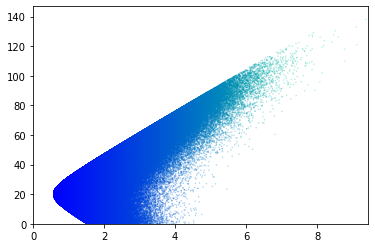



This is the result if we attempt to solve analytically
Best average return: 20.0
Minimum standard deviation: 0.3333333333333333
Best weights: [0.33 0.33 0.33]



In [14]:
# Example 6.9

returns = [10, 20, 30]

covariances = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

### Method 1: Solves the Markovitz using a numerical trial-and-error approach. Most robust but helps primatily to check answers only
print("\n\nThis is the result if we attempt to solve stuff randomly")
markowitz_random(returns, covariances, shorting = True)

# Method 2: Solves the Markovitz using the multivariable calculus approach in the book
print("\n\nThis is the result if we attempt to solve analytically")
markowitz_analytical(returns, covariances)
print()



This is the result if we attempt to solve stuff randomly
Best average return: 14.495447635892154
Minimum standard deviation: 0.6305454494337421
Best weights: [0.08 0.27 0.33 0.07 0.25]


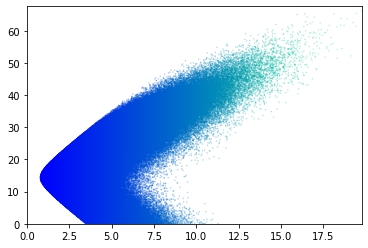



This is the result if we attempt to solve analytically
Best average return: 14.412865922482819
Minimum standard deviation: 0.6249392552670228
Best weights: [0.09 0.25 0.28 0.1  0.27]


Now assume the risk free rate is 10%


This is the result if we attempt to solve stuff randomly
Best average return: 17.220282287317733
Minimum standard deviation: 1.0593166557624105
Best weights: [ 0.35 -0.09  0.4  -0.14  0.47]


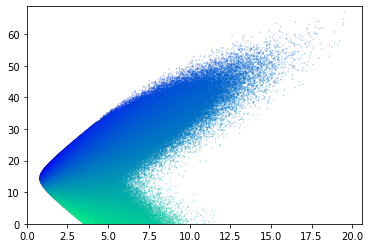



This is the result if we attempt to solve stuff analytically
Best average return: 16.989897881392707
Minimum standard deviation: 0.9898922045500025
Best weights: [ 0.32 -0.06  0.39 -0.11  0.47]


Suppose instead we want a target return of 25%. What is the lowest possible variance?
Best average return: 25.000000000000004
Minimum standard deviation: 6.784561730081626
Best weights: [ 1.03 -1.03  0.71 -0.78  1.07]



In [15]:
# Quiz 6 Q5-6
returns = [15.1, 12.5, 14.7, 9.02, 17.68]

cov = np.array([
    [ 2.30, 0.93,  0.62,  0.74, -0.23],
    [ 0.93, 1.40,  0.22,  0.56,  0.26],
    [ 0.62, 0.22,  1.80,  0.78, -0.27],
    [ 0.74, 0.56,  0.78,  3.40, -0.56],
    [-0.23, 0.26, -0.27, -0.56,  2.60]
])

np.random.seed(1)

print("\n\nThis is the result if we attempt to solve stuff randomly")
markowitz_random(returns, cov, shorting = True)

print("\n\nThis is the result if we attempt to solve analytically")
markowitz_analytical(returns, cov)

print("\n\nNow assume the risk free rate is 10%")
print("\n\nThis is the result if we attempt to solve stuff randomly")
markowitz_riskfree_random(returns, cov, 10)

print("\n\nThis is the result if we attempt to solve stuff analytically")
markowitz_riskfree_analytical(returns, cov, 10)

print("\n\nSuppose instead we want a target return of 25%. What is the lowest possible variance?")
markowitz_fixed_mean_analytical(returns, cov, 25)
print()